### Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析

- torch.nn.functional模块

- nn.Module模块


### 读取Mnist数据集
- 会自动进行下载

In [41]:
%matplotlib inline

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

784是mnist数据集每个样本的像素点个数

In [4]:
x_train[0].shape
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

(50000, 784)


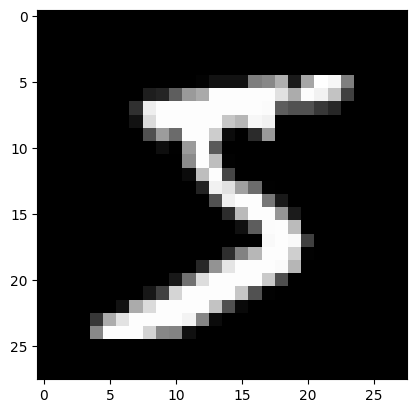

In [ ]:
from matplotlib import pyplot
import numpy as np
#cmap="gray" 灰度图
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

<img src="./img/4.png" alt="FAO" width="790">

<img src="./img/5.png" alt="FAO" width="790">

注意数据需转换成tensor才能参与后续建模训练


In [ ]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
# n 是样本的个数，c 是像素点的个数
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### torch.nn.functional 很多层和函数在这里都会见到

torch.nn.functional中有很多功能，后续会常用的。那什么时候使用nn.Module，什么时候使用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module，其他情况nn.functional相对更简单一些
 * torch.nn.functional是封装好的，但是灵活性不佳，nn.Module是实际开发中更常用的，便于自定义

In [7]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb.mm(weights) + bias

In [8]:
bs = 64 # batch_size 样本的个数
xb = x_train[0:bs]  # a mini-batch from x
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype = torch.float,  requires_grad = True) 
bs = 64
bias = torch.zeros(10, requires_grad=True)
# 损失函数 需要输入两个值 第一个是预测值，第二个是标签
print(loss_func(model(xb), yb))

tensor(15.7272, grad_fn=<NllLossBackward0>)


### 创建一个model来更简化代码

- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [ ]:
# nn模块就是神经网络了
from torch import nn

class Mnist_NN(nn.Module):
    # 构造函数
    def __init__(self):
        super().__init__()
        # 这里已经nn.Linear方法已经定义好了权重参数
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out  = nn.Linear(256, 10)
        # dropout 防止过拟合，0.5表示杀死50%的神经元
        self.dropout = nn.Dropout(0.5)

    # 前向传播，Torch中分为前向传播和反向传播，前向传播就是传进参数然后计算预测值的过程，反向传播主要是优化，Torch自带，一行代码就可以编写
    # 这里的 x 参数是 64 * 784 
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        # 在全链接过程中必须加入dropout，但是卷积可以不用
        x = self.dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x
        

In [10]:
net = Mnist_NN()
print(net)


Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


可以打印我们定义好名字里的权重和偏置项

In [12]:
# 遍历打印出 每个隐层的权重参数
for name, parameter in net.named_parameters():
    print(name, parameter,parameter.size())

hidden1.weight Parameter containing:
tensor([[ 0.0069,  0.0163,  0.0160,  ..., -0.0275,  0.0275, -0.0098],
        [ 0.0352, -0.0145,  0.0092,  ..., -0.0169,  0.0349, -0.0115],
        [ 0.0086, -0.0113,  0.0110,  ...,  0.0344,  0.0216,  0.0088],
        ...,
        [ 0.0262, -0.0171, -0.0053,  ...,  0.0158,  0.0136,  0.0230],
        [-0.0034, -0.0026,  0.0197,  ..., -0.0092,  0.0260,  0.0180],
        [ 0.0049, -0.0009, -0.0034,  ...,  0.0140,  0.0025,  0.0043]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([-0.0238,  0.0190, -0.0045, -0.0158, -0.0286,  0.0009, -0.0069, -0.0174,
        -0.0184, -0.0078,  0.0268,  0.0184,  0.0303,  0.0310,  0.0296, -0.0212,
        -0.0317,  0.0281,  0.0294, -0.0346,  0.0311, -0.0025,  0.0326,  0.0306,
        -0.0006, -0.0242,  0.0313, -0.0231, -0.0230,  0.0294, -0.0337,  0.0286,
         0.0330,  0.0211, -0.0337,  0.0313,  0.0212,  0.0172,  0.0092,  0.0351,
         0.0062, -0.0038, -0.0179,  0.0179, 

### 使用TensorDataset和DataLoader来简化

In [13]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
# shuffle 就是打乱样本的顺序
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [14]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [15]:
import numpy as np

def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(step), '验证集损失：'+str(val_loss))

In [21]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.Adam(model.parameters(), lr=0.001)

In [22]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        # 计算梯度
        loss.backward()
        # 根据梯度，更新权重
        opt.step()
        # 梯度清零
        opt.zero_grad()

    return loss.item(), len(xb)

### 三行搞定！

In [23]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(100, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：0.1777562872931361
当前step:1 验证集损失：0.14038255805820227
当前step:2 验证集损失：0.1179858381435275
当前step:3 验证集损失：0.1107424683753401
当前step:4 验证集损失：0.10240991352647542
当前step:5 验证集损失：0.09774479250572622
当前step:6 验证集损失：0.09132455458845944
当前step:7 验证集损失：0.09679921030793338
当前step:8 验证集损失：0.08993808611398563
当前step:9 验证集损失：0.08578289449326694
当前step:10 验证集损失：0.09019483960885555
当前step:11 验证集损失：0.08934408285841346
当前step:12 验证集损失：0.08703555625323206
当前step:13 验证集损失：0.0837827185086906
当前step:14 验证集损失：0.08226691671377048
当前step:15 验证集损失：0.08270146215418353
当前step:16 验证集损失：0.08551770655401052
当前step:17 验证集损失：0.08007037173761054
当前step:18 验证集损失：0.07825443392845337
当前step:19 验证集损失：0.08237732252993155
当前step:20 验证集损失：0.07874089258648455
当前step:21 验证集损失：0.08321938387306872
当前step:22 验证集损失：0.08219939473322593
当前step:23 验证集损失：0.08465245862061856
当前step:24 验证集损失：0.0811437179874163
当前step:25 验证集损失：0.07909511350432877
当前step:26 验证集损失：0.0788751167197479
当前step:27 验证集损失：0.07901946911145932
当前step:2

1. 将优化器由SGD修改成 Adam
2. 更改网络层数 和神经元个数 观察效果
3. 计算当前的准确率是多少

In [ ]:
# 正确率是要使用在验证集
correct = 0
total = 0
for xb,yb in valid_dl:
    outputs = model(xb)
    _,predicted = torch.max(outputs.data,1)# 最大值和索引
    total += yb.size(0)
    correct += (predicted == yb).sum().item()

print(100 * correct / total)

97.84
